In [1]:
# EDA: Single `data_train.hdf5` from t15.2023.08.13

# Quick exploratory data analysis on one training file from the Brain-to-Text ’25 dataset:
# - Load one HDF5 file
# - Inspect shapes & metadata
# - Split input features into Threshold Crossings (TC) and Spike-Band Power (SBP)
# - Basic distributions, correlations, and a quick heatmap

# > Note: This notebook expects a local file at `data/eda/t15.2023.08.13/data_train.hdf5`.

In [9]:
# Import and setup
import os, h5py, numpy as np, matplotlib.pyplot as plt
from collections import Counter

plt.rcParams["figure.figsize"] = (8, 4)
np.set_printoptions(suppress=True, linewidth=120)

In [10]:
# Adjust this path for your local file
H5_PATH = "../data/eda/t15.2023.08.13/data_train.hdf5"
assert os.path.exists(H5_PATH), f"File not found: {H5_PATH}"
H5_PATH

'../data/eda/t15.2023.08.13/data_train.hdf5'

In [11]:
# Minimal loader
def load_h5py_file(file_path):
    out = {
        "neural_features": [],  # (T, 512)
        "n_time_steps": [],
        "seq_class_ids": [],
        "seq_len": [],
        "transcriptions": [],
        "sentence_label": [],
        "session": [],
        "block_num": [],
        "trial_num": [],
    }
    with h5py.File(file_path, "r") as f:
        for trial_key in f.keys():
            g = f[trial_key]
            out["neural_features"].append(g["input_features"][:])
            out["n_time_steps"].append(g.attrs["n_time_steps"])
            out["seq_class_ids"].append(g["seq_class_ids"][:] if "seq_class_ids" in g else None)
            out["seq_len"].append(g.attrs["seq_len"] if "seq_len" in g.attrs else None)
            out["transcriptions"].append(g["transcription"][:] if "transcription" in g else None)
            out["sentence_label"].append(g.attrs["sentence_label"][:] if "sentence_label" in g.attrs else None)
            out["session"].append(g.attrs["session"])
            out["block_num"].append(g.attrs["block_num"])
            out["trial_num"].append(g.attrs["trial_num"])
    return out

data = load_h5py_file(H5_PATH)
len(data["neural_features"])

348

In [18]:
# Basic analysis
T_list = [arr.shape[0] for arr in data["neural_features"]]
feature_dims = set(arr.shape[1] for arr in data["neural_features"])
print(f"Number of trials: {len(T_list)}")
print(f"feature dims (should be 512): {feature_dims}")
print(f"median T bins/trial: {int(np.median(T_list))} | min: {min(T_list)} | max: {max(T_list)}")

Number of trials: 348
feature dims (should be 512): {512}
median T bins/trial: 729 | min: 239 | max: 1427


In [25]:
trial_idx = 0  # change to inspect another trial
X = data["neural_features"][trial_idx]  # shape (T, 512)
assert X.shape[1] == 512

TC  = X[:, :256]   # integer-ish counts per 20ms
SBP = X[:, 256:]   # continuous power

X.shape, TC.shape, SBP.shape

((1023, 512), (1023, 256), (1023, 256))

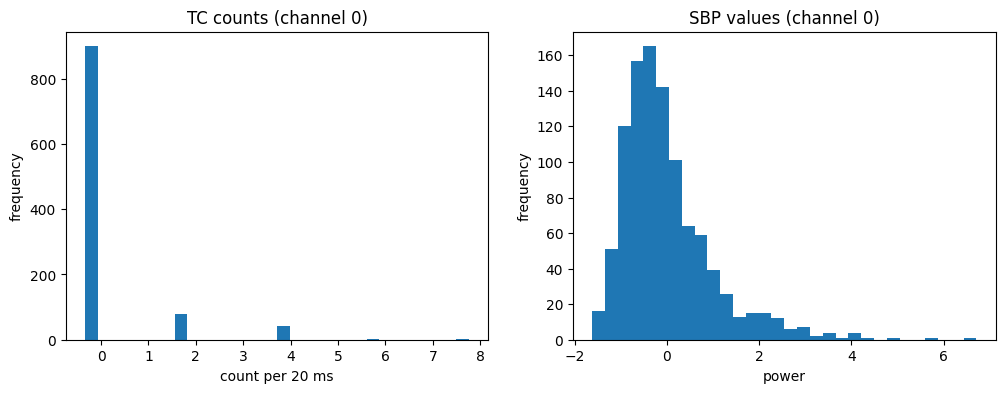

In [29]:
chan = 0  # try a few, e.g., 0, 32, 128, 255
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(TC[:, chan], bins=30)
axes[0].set_title(f"TC counts (channel {chan})")
axes[0].set_xlabel("count per 20 ms"); axes[0].set_ylabel("frequency")

axes[1].hist(SBP[:, chan], bins=30)
axes[1].set_title(f"SBP values (channel {chan})")
axes[1].set_xlabel("power"); axes[1].set_ylabel("frequency")
plt.show()

Per-channel TC↔SBP correlation:
  mean: 0.7480151972329077  | median: 0.7731061781997988


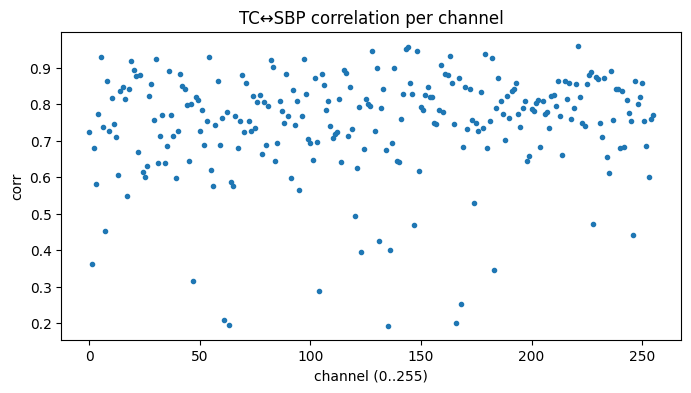

In [30]:
# correlation between TC and SBP for each electrode
def corr_nan(a, b):
    if a.std() == 0 or b.std() == 0: return np.nan
    return np.corrcoef(a, b)[0,1]

corrs = np.array([corr_nan(TC[:,i], SBP[:,i]) for i in range(256)])
print("Per-channel TC↔SBP correlation:")
print("  mean:", np.nanmean(corrs), " | median:", np.nanmedian(corrs))
plt.plot(corrs, marker='.', linestyle='none')
plt.title("TC↔SBP correlation per channel")
plt.xlabel("channel (0..255)"); plt.ylabel("corr")
plt.show()

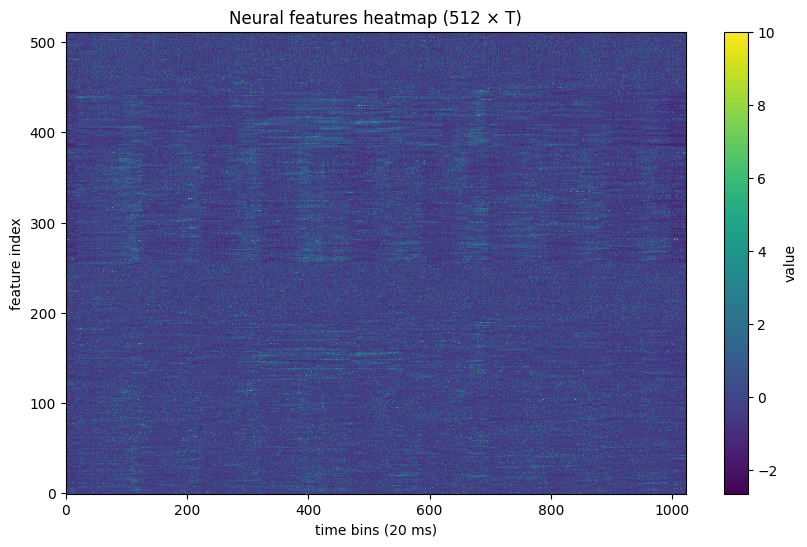

In [31]:
plt.figure(figsize=(10, 6))
plt.imshow(X.T, aspect="auto", origin="lower")
plt.title("Neural features heatmap (512 × T)")
plt.xlabel("time bins (20 ms)"); plt.ylabel("feature index")
plt.colorbar(label="value")
plt.show()

In [32]:
seq = data["seq_class_ids"][trial_idx]
if seq is not None:
    counts = Counter(seq.tolist())
    top = counts.most_common(10)
    print("Top 10 phoneme IDs in this trial:", top)
else:
    print("No seq_class_ids available in this split/trial.")

Top 10 phoneme IDs in this trial: [(0, 458), (40, 9), (17, 3), (38, 3), (31, 3), (3, 3), (4, 3), (36, 2), (8, 2), (23, 2)]
